In [1]:
# This code is provided for Deep Learning (CS 482/682) Homework 6 practice.
# The network structure is a simplified U-net. You need to finish the last layers
# @Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu
# Modified by Hongtao Wu on Oct 11, 2019 for Fall 2019 Machine Learning: Deep Learning HW6

#Jason Zhang Jzhan127

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

PATH = './modelparams'

# Plot training loss, validation loss
def plot(training_loss, validation_loss):
    plt.figure(300)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')   
    plt.plot(training_loss, 'b', label='Training')
    plt.plot(validation_loss, 'r', label= 'Validation')
    plt.legend()


# 1 D

In [2]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
    if useBN:
        # Use batch normalization
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    else:
        # No batch normalization
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )


# Upsampling
def upsample(ch_coarse, ch_fine):
    return nn.Sequential(
        nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
        nn.ReLU()
        )


# U-Net
class unet(nn.Module):
    def __init__(self, useBN=False):
        super(unet, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

        #TODO: Design your last layer & activations
#         self.convLast = add_conv_stage(32, 8, useBN=useBN, kernel_size=1, padding=0)
        self.convLast = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        convfinal_out = self.convLast(conv1m_out)

        return torch.softmax(convfinal_out, dim=1)

In [3]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.01
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 5

# TODO: Design your own dataset
class ImageDataset(Dataset):
    def __init__(self, input_dir):
        datalist = []
        labellist = []
        onehotlabellist = []
        for folders in os.listdir(input_dir):
            new_dir = os.path.join(input_dir, folders)
            if os.path.isdir(new_dir):
                impath = new_dir+ '/'+folders+'_gray.jpg'
                labelpath = new_dir+ '/'+folders+'_input.jpg'
                im = Image.open(impath)
                imLab = Image.open(labelpath)
                im = np.array(im)
                im = np.expand_dims(im, axis = 2)
                datalist.append(im)
                labellist.append(np.array(imLab)/255)
                
        self.data = torch.from_numpy(np.transpose(np.array(datalist), (0, 3, 1, 2))).type('torch.FloatTensor')
        self.label = torch.from_numpy(np.transpose(np.array(labellist), (0, 3, 1, 2))).type('torch.FloatTensor')

    def __len__ (self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


loss = nn.MSELoss()

# TODO: Use your designed dataset for dataloading
train_dataset=ImageDataset(input_dir = "./HW6_data/colorization/train_cor/")
validation_dataset=ImageDataset(input_dir =  "./HW6_data/colorization/validation_cor/")
model = unet(useBN = True)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                           batch_size=validation_batch_size, 
                                           shuffle=True)

training_loss = []
validation_loss = []
training_iter = iter(train_loader)
validation_iter = iter(validation_loader)
print("Start Training...")
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    count = 0
    training_loss_tot = 0
    for ind, training_data in enumerate(train_loader):
        inp = training_data[0].numpy()
        stack_data = np.stack((inp, inp, inp), axis = 1)
        stack_data = stack_data.reshape((stack_data.shape[0], stack_data.shape[1], stack_data.shape[3], stack_data.shape[4]))
        data = torch.from_numpy(stack_data)
        x = autograd.Variable(data).cuda()
        y = autograd.Variable(training_data[1]).cuda()

        optimizer.zero_grad()
        y_hat = model(x)
        train_loss = loss(y_hat, y)
        train_loss.backward()
        optimizer.step()
        training_loss_tot += train_loss.data
        count += 1
    training_loss.append(training_loss_tot / count)    
    print(training_loss_tot / count)

    ########################### Validation #####################################
    # TODO: Design your own validation section
    print("\nStart Validation...")
    count = 0
    val_loss_tot = 0
    model.eval()
    with torch.no_grad():
        for ind, valid_data in enumerate(validation_loader):
            inp = valid_data[0].numpy()
            stack_data = np.stack((inp, inp, inp), axis = 1)
            stack_data = stack_data.reshape((stack_data.shape[0], stack_data.shape[1], stack_data.shape[3], stack_data.shape[4]))
            data = torch.from_numpy(stack_data)
            x = autograd.Variable(data).cuda()
            y = autograd.Variable(valid_data[1]).cuda()
            y_hat = model(x)
            val_loss = loss(y_hat, y)
            val_loss_tot += val_loss.data
            count += 1
        validation_loss.append(val_loss_tot/count)
        print(val_loss_tot/count)

Start Training...

EPOCH 1 of 5

tensor(0.0354, device='cuda:0')

Start Validation...
tensor(0.0285, device='cuda:0')

EPOCH 2 of 5

tensor(0.0348, device='cuda:0')

Start Validation...
tensor(0.0287, device='cuda:0')

EPOCH 3 of 5

tensor(0.0347, device='cuda:0')

Start Validation...
tensor(0.0287, device='cuda:0')

EPOCH 4 of 5

tensor(0.0347, device='cuda:0')

Start Validation...
tensor(0.0283, device='cuda:0')

EPOCH 5 of 5

tensor(0.0346, device='cuda:0')

Start Validation...
tensor(0.0281, device='cuda:0')


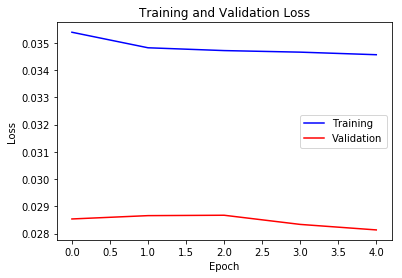

In [4]:
plot(training_loss, validation_loss)

# 1 E

In [6]:
torch.save(model.state_dict(), PATH)

In [3]:
modelPre = unet(useBN = True)
modelPre.load_state_dict(torch.load(PATH))
modelPre.convLast = nn.Conv2d(32, 8, kernel_size=1)

In [6]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.01
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 5

class ImageDatasetSeg(Dataset):
    def __init__(self, input_dir):
        datalist = []
        labellist = []
        onehotlabellist = []
        for folders in os.listdir(input_dir):
            new_dir = os.path.join(input_dir, folders)
            if os.path.isdir(new_dir):
                impath = new_dir+ '/'+folders+'_input.jpg'
                labelpath = new_dir+ '/'+folders+'_mask.png'
                im = Image.open(impath)
                imLab = Image.open(labelpath)
                datalist.append(np.array(im))
                labellist.append(np.array(imLab))
        test = np.transpose(np.array(datalist), (0, 3, 1, 2))
        self.data = torch.from_numpy(np.transpose(np.array(datalist), (0, 3, 1, 2))).type('torch.FloatTensor')
        npLabel = np.array(labellist)
        labels = [0, 32, 64, 96, 128, 160, 192, 224]
        print("start process")
        for i in npLabel:
            imgs = []
            for j in labels:
                mask = self.mask(i, j)
                imgs.append(mask)
            onehotlabellist.append(np.array(imgs))
        print("finish process")
        self.label = torch.from_numpy(np.array(onehotlabellist)).type('torch.FloatTensor')
        
        
    def mask(self, label, val):
        return label == val
        
    def __len__ (self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
    
    
def dice_coeff(y_hat, y):
    eps = 1
    loss = 0
    classes = y_hat.shape[0]
    total = 0
    for i in range(classes):
        flatInp = y_hat[i].flatten()
        flatLabel = y[i].flatten()
        intersect = (flatInp * flatLabel).sum()
        total += ((2. * intersect + eps) /
                    (flatInp.sum() + flatLabel.sum() + eps))
    return total / classes
    
# TODO: Implement DICE loss
class DICELoss(nn.Module):
    def forward(self, y_hat, y):
        dice = dice_coeff(y_hat, y)
        return 1 - dice
 

# TODO: Use your designed dataset for dataloading
train_dataset_seg=ImageDatasetSeg(input_dir = "./HW6_data/segmentation/train/")
validation_dataset_seg=ImageDatasetSeg(input_dir =  "./HW6_data/segmentation/validation/")
modelPre.cuda()
optimizer = torch.optim.Adam(modelPre.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_seg, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset_seg, 
                                           batch_size=validation_batch_size, 
                                           shuffle=True)

training_loss = []
validation_loss = []
print("Start Training...")
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    modelPre.train()
    train_tot = 0
    count = 0
    for ind, training_data in enumerate(train_loader):
        x = autograd.Variable(training_data[0]).cuda()
        y = autograd.Variable(training_data[1]).long().cuda()

        optimizer.zero_grad()
        y_hat = modelPre(x)
        train_loss = DICELoss()(y_hat, y)
        train_loss.backward()
        optimizer.step()
        train_tot += train_loss.data.item()
        count += 1
    print(train_tot/count)
    training_loss.append(train_tot/count)
    

    ########################### Validation #####################################
    # TODO: Design your own validation section
    print("\nStart Validation...")
    count = 0
    val_loss_tot = 0
    modelPre.eval()
    with torch.no_grad():
        for ind, valid_data in enumerate(validation_loader):
            x = autograd.Variable(valid_data[0]).cuda()
            y = autograd.Variable(valid_data[1]).cuda()
            y_hat = modelPre(x)
            val_loss = DICELoss()(y_hat, y)
            val_loss_tot += val_loss.data
            count += 1
        validation_loss.append(val_loss_tot/count)
        print(val_loss_tot/count)


start process
finish process
start process
finish process
Start Training...

EPOCH 1 of 5

0.1094172219435374

Start Validation...
tensor(0.1637, device='cuda:0')

EPOCH 2 of 5

0.10956636667251587

Start Validation...
tensor(0.1259, device='cuda:0')

EPOCH 3 of 5

0.1060882290204366

Start Validation...
tensor(0.1261, device='cuda:0')

EPOCH 4 of 5

0.10140520135561625

Start Validation...
tensor(0.1148, device='cuda:0')

EPOCH 5 of 5

0.10025479793548583

Start Validation...
tensor(0.1062, device='cuda:0')


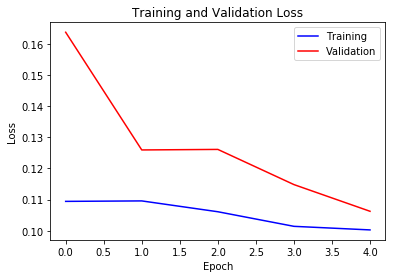

In [7]:
plot(training_loss, validation_loss)

start process
finish process
Average Dice Score Accuracy:  0.8901723384857178


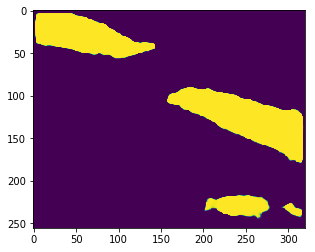

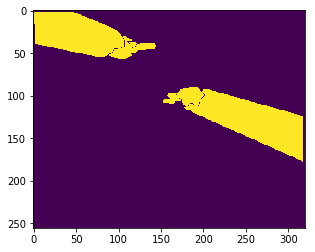

In [8]:
test_dataset=ImageDatasetSeg(input_dir = "./HW6_data/segmentation/test/")    
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                       batch_size=10)
def dice_coeff(y_hat, y):
    eps = 1
    loss = 0
    classes = y_hat.shape[0]
    total = 0
    for i in range(classes):
        flatInp = y_hat[i].flatten()
        flatLabel = y[i].flatten()
        intersect = (flatInp * flatLabel).sum()
        total += ((2. * intersect + eps) /
                    (flatInp.sum() + flatLabel.sum() + eps))
    return total / classes
    
score_sum = 0
count = 0
with torch.no_grad():    
    for ind, data in enumerate(test_loader):
        modelPre.eval()
        x = autograd.Variable(data[0]).cuda()
        y = autograd.Variable(data[1]).long().cuda()
        y_hat = modelPre(x)
        plt.figure(100)
        plt.imshow(y_hat[0][3].cpu().detach())
        plt.figure(200)
        plt.imshow(y[0][3].cpu().detach())
        acc = dice_coeff(y_hat, y)
        score_sum += acc.item()
        count += 1
        
    print("Average Dice Score Accuracy: ", score_sum / count);